In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import random
from collections import defaultdict

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
YEAR = 2014
raw_tournament_df = pd.read_csv(f"{DATA_DIR}/output/teams.csv")
tournament_df = raw_tournament_df[raw_tournament_df["Season"] == YEAR]
tournament_df

,Season,TeamID,TeamName,Seed,SeedInt,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,SOS,Competition,Wins
19,2014,1107,SUNY Albany,X16a,16,-0.271488,-0.348533,-2.155794,-0.137483,-1.190929,-0.787103,0.0
23,2014,1110,American Univ,Z15,15,-0.401436,-0.892691,-4.801786,-0.161573,-0.752242,-0.526535,0.0
33,2014,1112,Arizona,Z01,1,0.347633,-1.169730,-3.516876,5.982980,2.136847,1.296823,3.0
40,2014,1113,Arizona St,Y10,10,0.463077,-0.088840,1.445271,3.242552,1.730326,1.224159,0.0
61,2014,1124,Baylor,Z06,6,0.177439,-0.461394,-1.647693,3.945884,2.281409,1.497495,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1077,2014,1454,WI Milwaukee,W15,15,0.071497,0.164592,1.267403,-0.237351,-0.465646,-0.103613,0.0
1081,2014,1455,Wichita St,Y01,1,0.548812,-0.852261,-0.964781,5.231957,0.146061,0.195660,1.0
1103,2014,1458,Wisconsin,Z02,2,0.557277,-0.492815,-3.297110,5.597094,1.921237,1.162720,4.0
1110,2014,1459,Wofford,Y15,15,-0.498361,-0.687146,-4.894077,-0.998533,-1.112364,-0.816301,0.0


In [4]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
# Get slots, and order with play ins first
slots_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySlots.csv")
slots_df = slots_df[slots_df["Season"] == YEAR]
slots_df = pd.concat([
    slots_df[~slots_df["Slot"].str.startswith("R")],
    slots_df[slots_df["Slot"].str.startswith("R")]
])
slots_df

,Season,Slot,StrongSeed,WeakSeed
1912,2014,X16,X16a,X16b
1913,2014,Y11,Y11a,Y11b
1914,2014,Y12,Y12a,Y12b
1915,2014,Y16,Y16a,Y16b
1849,2014,R1W1,W01,W16
...,...,...,...,...
1907,2014,R4Y1,R3Y1,R3Y2
1908,2014,R4Z1,R3Z1,R3Z2
1909,2014,R5WX,R4W1,R4X1
1910,2014,R5YZ,R4Y1,R4Z1


In [5]:
games_df = pd.read_csv(f"{DATA_DIR}/output/games_training.csv")
games_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OwnScore_Zscore_B,OppScore_Zscore_A,OppScore_Zscore_B,Offense_A,Offense_B,Dominance_A,Dominance_B,SOS_A,SOS_B,Competition_A,Competition_B,Win_A
0,2003,1104,1328,0.144799,0.207507,-0.335313,-0.863963,-0.755118,-3.573729,3.420866,3.564441,1.808134,2.096693,1.378513,1.181115,True
1,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.573729,2.197156,3.564441,4.765952,2.096693,2.262017,1.181115,1.321327,False
2,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.573729,2.197156,3.564441,4.765952,2.096693,2.262017,1.181115,1.321327,False
3,2003,1281,1328,0.297116,0.207507,-0.342031,-0.863963,-0.563626,-3.573729,3.422770,3.564441,2.253370,2.096693,1.340966,1.181115,True
4,2003,1328,1329,0.207507,-0.064060,-0.863963,-0.740947,-3.573729,-1.235750,3.564441,2.115383,2.096693,1.873838,1.181115,1.223438,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4952,2019,1209,1243,0.283263,-0.404416,0.032907,-1.112603,1.561783,-5.395697,1.030749,2.069185,0.129268,1.852485,0.113073,1.377838,False
4953,2019,1209,1285,0.283263,0.099479,0.032907,-0.340951,1.561783,-2.116064,1.030749,-0.055944,0.129268,-0.800677,0.113073,-0.561377,False
4954,2019,1209,1251,0.283263,-0.223065,0.032907,-0.890404,1.561783,-6.511350,1.030749,0.485783,0.129268,-0.427815,0.113073,-0.157060,False
4955,2019,1124,1341,0.171236,0.336226,-0.367754,0.325131,-0.346217,2.933735,1.919531,-1.405578,1.525256,-1.674359,1.131600,-0.969110,True


In [6]:
# Train predictor based on derived offense and quality metrics
predict_df = games_df[[
    "OwnScore_Zscore_A", "OwnScore_Zscore_B",
    "OppScore_Zscore_A", "OppScore_Zscore_B",
    "Offense_A", "Offense_B",
    "Dominance_A", "Dominance_B",
    "SOS_A", "SOS_B",
    "Competition_A", "Competition_B"
]]

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(predict_df),
    columns=predict_df.columns
) 

reg = LogisticRegression().fit(
    data_scaled,
    games_df[["Win_A"]]
)
reg.score(
    data_scaled,
    games_df[["Win_A"]]
), reg.coef_

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.6572523703853137,
 array([[ 0.33550312, -0.38278249, -0.40732479,  0.33624574, -0.00098818,
          0.10131534,  0.17153791, -0.15993257,  0.05296985, -0.00327402,
          0.52275839, -0.52320095]]))

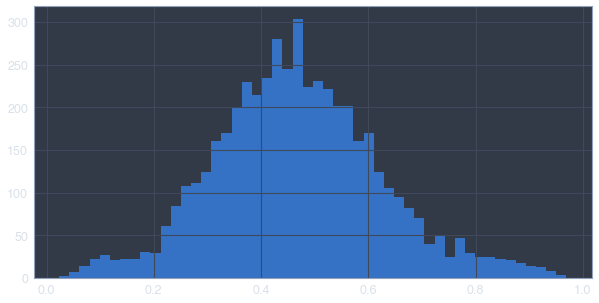

In [7]:
# Sanity check probability distribution
plt.figure(figsize=(10,5));
probs = [
    a for a, b in reg.predict_proba(predict_df)
]
plt.hist(probs, bins=50);

In [8]:
from functools import lru_cache

@lru_cache(maxsize=4096)
def calc_prob(predict_data):
    return reg.predict_proba(scaler.transform([predict_data]))[0][1]

def get_power_rating(team):
    return calc_prob((
            team["OwnScore_Zscore"], 0,
            team["OppScore_Zscore"], 0,
            team["Offense"], 0,
            team["Dominance"], 0,
            team["SOS"], 0,
            team["Competition"], 0,
        ))

In [9]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    for line in range(len(x)):
         p1.text(
             x.iloc[line]+0.02, y.iloc[line], 
             labelseries.iloc[line], size=labelsize, color=labelcolor
         )
    return p1

In [10]:
# Best teams of all time
raw_tournament_df["PowerRating"] = raw_tournament_df.apply(get_power_rating, axis=1)
raw_tournament_df["PowerOdds"] = raw_tournament_df["PowerRating"] / (1-raw_tournament_df["PowerRating"])
raw_tournament_df["PowerLogOdds"] = np.log(raw_tournament_df["PowerOdds"])

raw_tournament_df.sort_values(by="PowerRating", ascending=False)[[
    "Season", "TeamName", "Seed", "PowerRating"
]][:25]

,Season,TeamName,Seed,PowerRating
403,2015,Kentucky,Y01,0.986821
514,2019,Michigan St,W02,0.981353
208,2004,Duke,W01,0.979966
223,2019,Duke,W01,0.979681
1030,2019,Virginia,Z01,0.977671
612,2005,North Carolina,Z01,0.977099
33,2014,Arizona,Z01,0.977092
1104,2015,Wisconsin,Z01,0.976900
371,2010,Kansas,Y01,0.975950
209,2005,Duke,Y01,0.975685


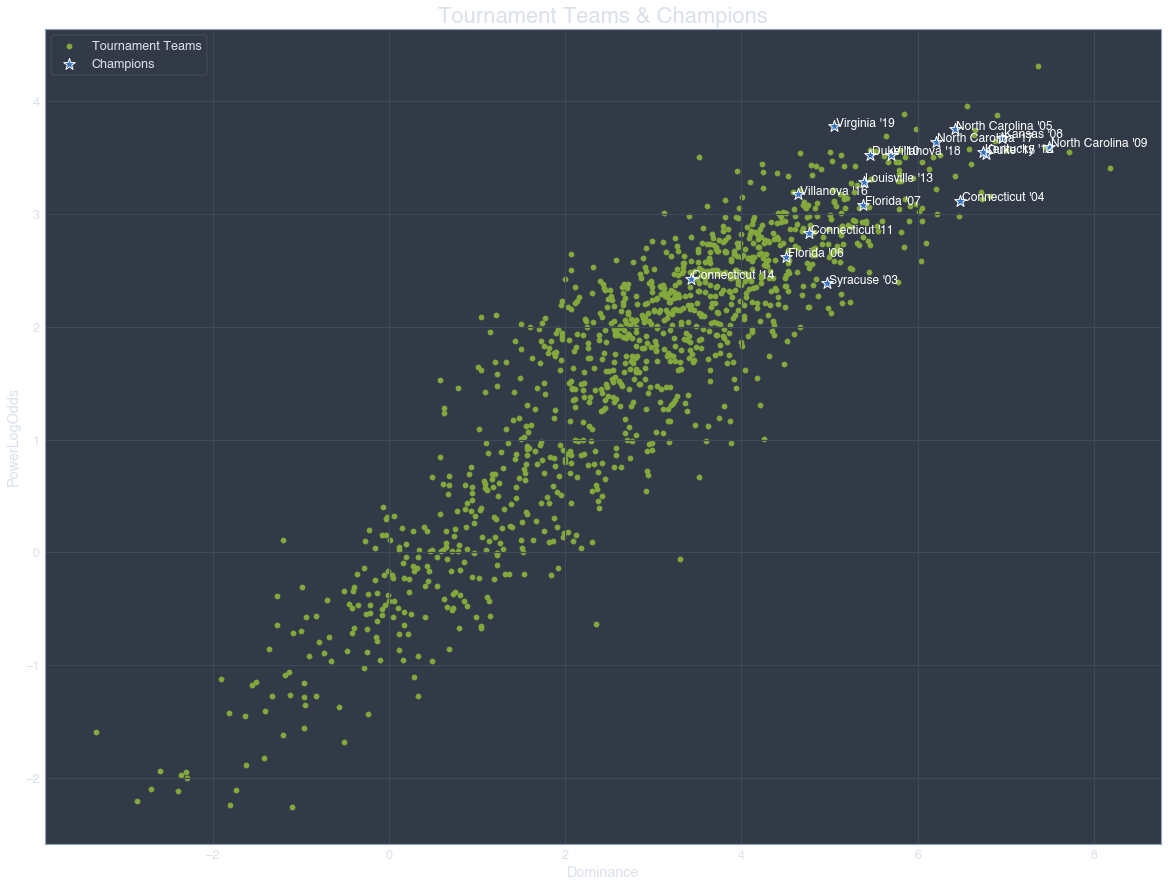

In [11]:
is_champion = raw_tournament_df["Wins"] >= 6
label_series = (
    raw_tournament_df[is_champion]["TeamName"] + " '" +
    raw_tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("Tournament Teams & Champions", fontsize=22)
plt.scatter(raw_tournament_df["Dominance"], raw_tournament_df["PowerLogOdds"], color='g', label='Tournament Teams');
scatter_text(
    raw_tournament_df[is_champion]["Dominance"], raw_tournament_df[is_champion]["PowerLogOdds"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

In [12]:
power_ratings = {}

SIMULATION_ROUNDS = 10000
total_stats = defaultdict(lambda: defaultdict(int))
for i in tqdm(range(SIMULATION_ROUNDS)):
    # INITIALIZE BRACKET (will be updated durign simulation)
    slots_dict = {
        row["Seed"]: row
        for _, row in tournament_df.iterrows()
    }
    
    for i, r in slots_df.iterrows():
        team_a = slots_dict[r["StrongSeed"]]
        team_b = slots_dict[r["WeakSeed"]]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["Offense"], team_b["Offense"],
            team_a["Dominance"], team_b["Dominance"],
            team_a["SOS"], team_b["SOS"],
            team_a["Competition"], team_b["Competition"],
        )
        prob = calc_prob(predict_data)
        winning_team = team_a if random.random() < prob else team_b
        slots_dict[r["Slot"]] = winning_team
        total_stats[winning_team["TeamID"]]["wins"] += 1
        if r["Slot"][1] == "3":
            total_stats[winning_team["TeamID"]]["elite8"] += 1
        if r["Slot"][1] == "4":
            total_stats[winning_team["TeamID"]]["final4"] += 1
        
        # Get "difficulty" by looking at opposing power ratings
        power_a = get_power_rating(team_a)
        power_ratings[team_a["TeamID"]] = power_a
        total_stats[team_b["TeamID"]]["opp_power"] += power_a
        total_stats[team_b["TeamID"]]["opp_power_count"] += 1
        
        power_b = get_power_rating(team_b)
        power_ratings[team_b["TeamID"]] = power_b
        total_stats[team_a["TeamID"]]["opp_power"] += power_b
        total_stats[team_a["TeamID"]]["opp_power_count"] += 1
    
    # last winning team is champion
    total_stats[winning_team["TeamID"]]["championships"] +=1

100%|██████████| 10000/10000 [01:37<00:00, 102.12it/s]


In [13]:
power_df = pd.DataFrame([{"TeamID": k, "PowerRating": v} for k, v in power_ratings.items()])
tournament_df = tournament_df.merge(power_df, on="TeamID")

In [14]:
simulation_df = pd.DataFrame([
    {
        "TeamID": team_id,
        "AvgOppPower": results_dict["opp_power"] / results_dict["opp_power_count"],
        "MeanWins": results_dict["wins"] / SIMULATION_ROUNDS,
        "PercentElite8": results_dict["elite8"] / SIMULATION_ROUNDS,
        "PercentFinal4": results_dict["final4"] / SIMULATION_ROUNDS,
        "PercentChampion": results_dict["championships"] / SIMULATION_ROUNDS
    }
    for team_id, results_dict in total_stats.items()
])
simulation_df = simulation_df.merge(tournament_df, on="TeamID")[[
    "TeamID", "TeamName", "Seed",
    "Offense",
    "Dominance",
    "Competition",
    "AvgOppPower",
    "PowerRating",
    "MeanWins",
    "PercentElite8",
    "PercentFinal4",
    "PercentChampion",
    "Wins"
]]

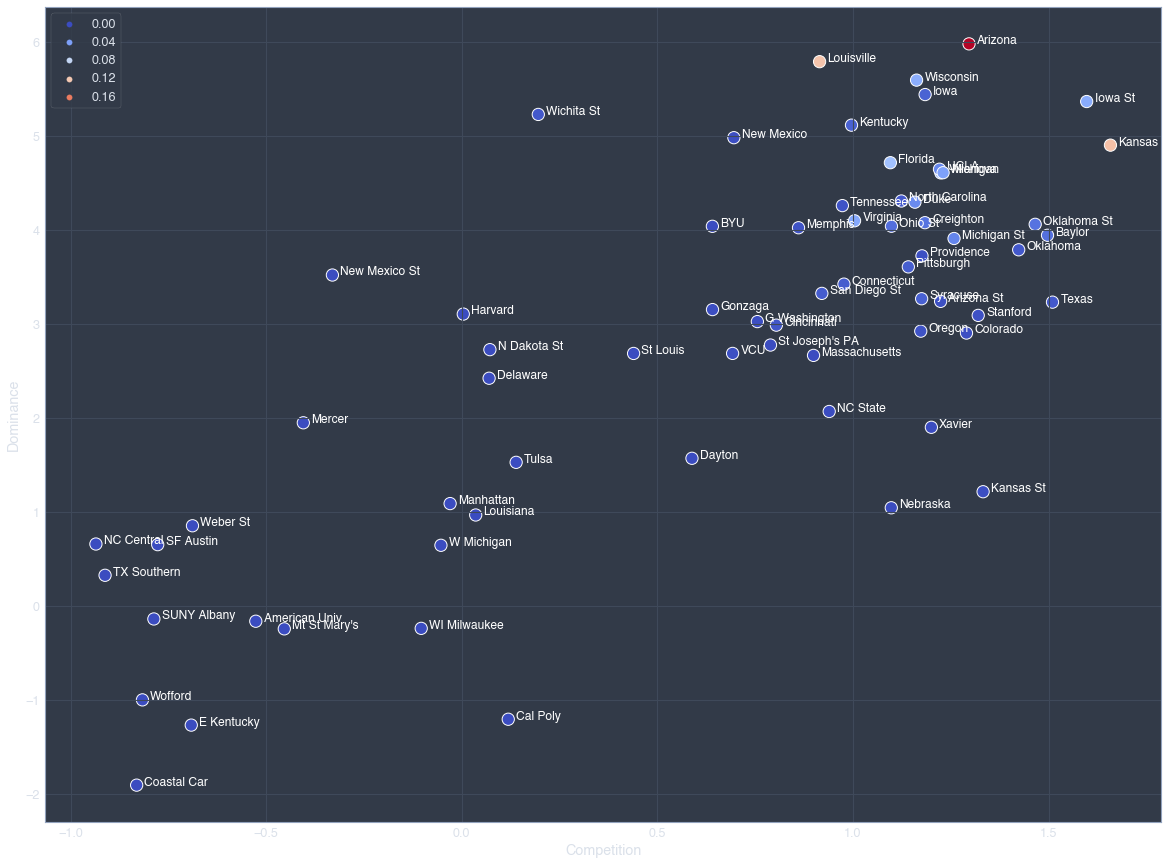

In [15]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["Competition"], y=simulation_df["Dominance"], s=150,
    hue=simulation_df["PercentChampion"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=simulation_df["TeamName"], labelcolor="white",
);
plt.legend(loc='upper left');

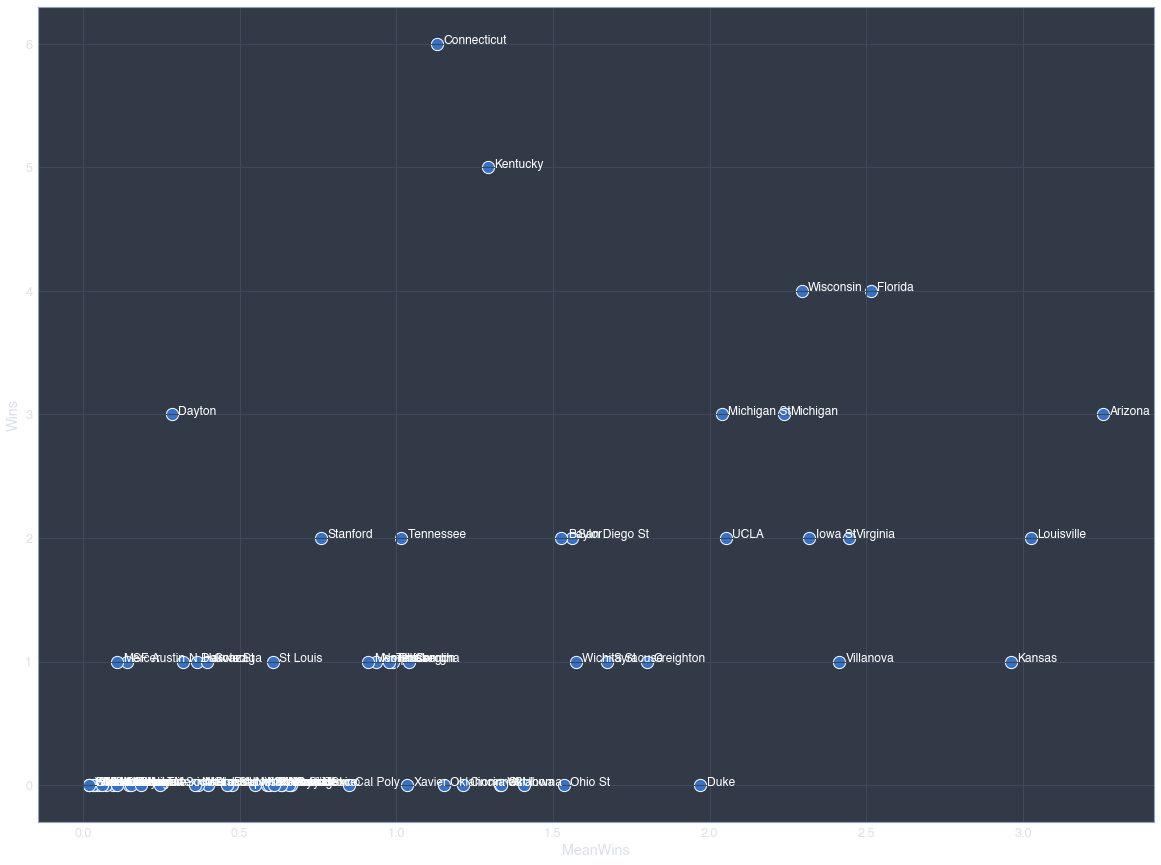

In [16]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["MeanWins"], y=simulation_df["Wins"], s=150,
    labelseries=simulation_df["TeamName"], labelcolor="white"
);

In [17]:
BASIC_COLUMNS = ["TeamName", "Seed", "MeanWins", "PercentElite8", "PercentFinal4", "PercentChampion"]

In [24]:
# Who is the best team?
simulation_df.sort_values("PowerRating", ascending=False)[["PowerRating"] + BASIC_COLUMNS][:30]

,PowerRating,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
52,0.977092,Arizona,Z01,3.2551,0.5991,0.4413,0.1958
25,0.967606,Kansas,X02,2.9609,0.5387,0.3474,0.1254
44,0.967431,Louisville,Y04,3.0240,0.5727,0.3795,0.1229
24,0.955214,Florida,X01,2.5138,0.4395,0.2354,0.0605
10,0.951691,Villanova,W02,2.4124,0.3739,0.2218,0.0568
54,0.949646,Wisconsin,Z02,2.2936,0.3806,0.1682,0.0480
12,0.949189,Iowa St,W03,2.3182,0.3562,0.2156,0.0473
66,0.947096,Oklahoma St,Z09,1.1524,0.1323,0.0713,0.0181
40,0.946192,Michigan,Y02,2.2380,0.3441,0.1729,0.0409
8,0.943989,Virginia,W01,2.4447,0.4198,0.2091,0.0446


In [19]:
# Who has the easiest schedule on average (excluding play ins)
is_not_play_in =  ~simulation_df["Seed"].str[-1].apply(str.isalpha)
simulation_df[is_not_play_in].sort_values(
    "AvgOppPower", ascending=True)[["AvgOppPower"] + BASIC_COLUMNS][:16]

,AvgOppPower,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
8,0.711682,Virginia,W01,2.4447,0.4198,0.2091,0.0446
40,0.739279,Michigan,Y02,2.2380,0.3441,0.1729,0.0409
24,0.741349,Florida,X01,2.5138,0.4395,0.2354,0.0605
39,0.742372,Wichita St,Y01,1.5720,0.1505,0.0535,0.0055
31,0.743550,VCU,X05,1.3316,0.0963,0.0290,0.0022
10,0.765319,Villanova,W02,2.4124,0.3739,0.2218,0.0568
25,0.770413,Kansas,X02,2.9609,0.5387,0.3474,0.1254
27,0.772780,Syracuse,X03,1.6724,0.1674,0.0661,0.0097
54,0.788088,Wisconsin,Z02,2.2936,0.3806,0.1682,0.0480
12,0.789287,Iowa St,W03,2.3182,0.3562,0.2156,0.0473


In [20]:
# Who has the best chance to win
pie_df = simulation_df.sort_values("PercentChampion", ascending=False)
pie_df[[
    "TeamName", "Seed", "PowerRating", "AvgOppPower", "PercentElite8", "PercentFinal4", "PercentChampion"
]][:10]

,TeamName,Seed,PowerRating,AvgOppPower,PercentElite8,PercentFinal4,PercentChampion
52,Arizona,Z01,0.977092,0.794928,0.5991,0.4413,0.1958
25,Kansas,X02,0.967606,0.770413,0.5387,0.3474,0.1254
44,Louisville,Y04,0.967431,0.838165,0.5727,0.3795,0.1229
24,Florida,X01,0.955214,0.741349,0.4395,0.2354,0.0605
10,Villanova,W02,0.951691,0.765319,0.3739,0.2218,0.0568
54,Wisconsin,Z02,0.949646,0.788088,0.3806,0.1682,0.0480
12,Iowa St,W03,0.949189,0.789287,0.3562,0.2156,0.0473
8,Virginia,W01,0.943989,0.711682,0.4198,0.2091,0.0446
40,Michigan,Y02,0.946192,0.739279,0.3441,0.1729,0.0409
42,Duke,Y03,0.940792,0.821882,0.2960,0.1412,0.0294


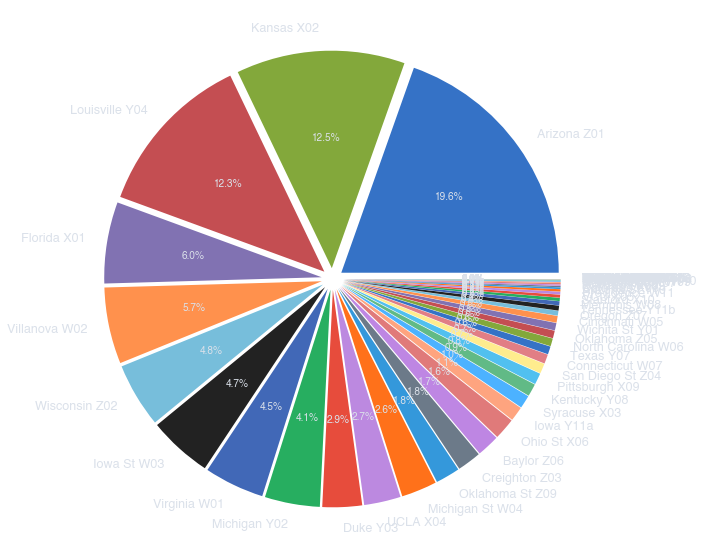

In [21]:
plt.figure(figsize=(10,10));
plt.pie(
    x=pie_df["PercentChampion"],
    labels=pie_df["TeamName"] + " " + pie_df["Seed"],
    autopct="%.1f%%",
    explode=[0.05]*len(simulation_df),
);

In [22]:
# Submit to Kaggle
import itertools
predictions = []
for year in range(2015, 2020):
    submit_df = raw_tournament_df[raw_tournament_df["Season"] == year].set_index(["Season", "TeamID"])
    ids = sorted(submit_df.loc[year].index)
    for id_a, id_b in itertools.product(ids, ids):
        if id_a >= id_b:
            continue
        team_a = submit_df.loc[(year, id_a)]
        team_b = submit_df.loc[(year, id_b)]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["Offense"], team_b["Offense"],
            team_a["Dominance"], team_b["Dominance"],
            team_a["SOS"], team_b["SOS"],
            team_a["Competition"], team_b["Competition"],
        )
        prob = calc_prob(predict_data)
        predictions.append({
            "ID": f"{year}_{id_a}_{id_b}",
            "Pred": prob
        })

In [23]:
pred_df = pd.DataFrame(predictions)
pred_df.to_csv(f"{DATA_DIR}/output/kaggle_submission.csv", index=False)